In [1]:
using Distributions
using PyPlot
using Color

INFO: Loading help data...


In [2]:
function get_colors(N)
    h = 0
    col = zeros(3,N)
    for i = 1:N
        color = convert(RGB, HSL((h%1)*360, 0.5, 0.5));
        col[:,i] = [color.r color.g color.b]
        h += 0.618033988749895 # silver ratio
    end
    return col
end

function plot_meth(X,c)
    nc = int(maximum(c)) # number of clusters
    col = get_colors(nc)
    N,W = size(X)
    ind = sortperm(c)
    y = 1
    for n = ind
        plot([0.5,W+0.5],[y,y],"-",color=col[:,c[n]])
        for w = 1:W
            if X[n,w]
                plot(w,y,"o",color=col[:,c[n]])
            else
                plot(w,y,"o",color=col[:,c[n]],mfc="w")
            end
        end
        y += 1
    end
    xlim([0,1+W])
    ylim([0,1+N])
    xticks([])
    yticks([])
    title("All reads, with assigned clusters")
end

function plot_meth_avg(X,c)
    nc = int(maximum(c)) # number of clusters
    col = get_colors(nc)
    N,W = size(X)
    
    for cc = 1:nc
        Xavg = mean(X[c .== cc,:],1)
        plot([0.5,W+0.5],[cc,cc],"-",color=col[:,cc])
        for w = 1:W
            color = Xavg[w]*col[:,cc] + (1- Xavg[w])*[1,1,1];
            plot(w,cc,"o",color=color)
        end
    end
    xlim([0,1+W])
    ylim([0,1+nc])
    xticks([])
    yticks([])
    title("average methylation pattern")
end

plot_meth_avg (generic function with 1 method)

In [3]:
function beta_binomial_likelihood(Xc,G)
    # Computes the likelihood for a subset of the data, Xc
    n = size(Xc,1)
    x_sum = sum(Xc,1)
    return sum(lgamma(n + 1) + 
               lgamma(x_sum + G["a"]) + 
               lgamma(n - x_sum + G["b"]) + 
               lgamma(G["a"] + G["b"]) - 
               lgamma(x_sum + 1) - 
               lgamma(n - x_sum + 1) - 
               lgamma(n + G["a"] + G["b"]) - 
               lgamma(G["a"]) - 
               lgamma(G["b"]))
end

beta_binomial_likelihood (generic function with 1 method)

In [4]:
# the likelihood function should be higher when likelihoods are computed separately for each cluster?

L0 = beta_binomial_likelihood(X,G)
L1 = 0
for cc = 1:maximum(c)
    L1 += beta_binomial_likelihood(X[c.==cc,:],G)
end

println(L0)
println(L1)
println(L1/maximum(c))

LoadError: X not defined
while loading In[4], in expression starting on line 3

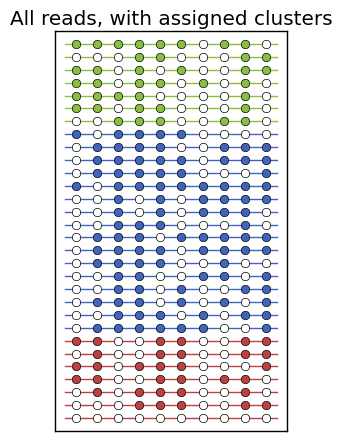

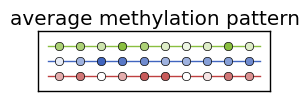

In [5]:
## PRIOR DISTRIBUTION
# Blackwell-MacQueen urn scheme
N = 30 # number of reads
W = 10 # number of sites per read
X = bool(zeros(N,W))
P = zeros(1,W)
G = {"a"=>ones(1,W),"b"=>ones(1,W)} # alpha and beta for beta prior
alpha = 1 # dispersion parameter for Dirichlet Process

# initialize probabilities for first cluster
for w = 1:W
    a,b = G["a"][w],G["b"][w]
    P[1,w] = rand(Beta(a,b))
end
c = zeros(N)
c[1] = 1

for n = 2:N
    # sample from categorical distribution with probability vector p_
    #  -- A new cluster is formed with probability alpha/(alpha+n-1)
    #  -- Each old datapoint has probability 1/(alpha+n-1) of being reused
    p_ = [ones(n-1)/(n-1+alpha), alpha/(n-1+alpha)]
    j = rand(Categorical(p_))
    if j <= (n-1) 
        c[n] = c[j] # Re-use cluster c[j]
    else
        # Make a new cluster
        P = [P;zeros(1,W)]
        for w = 1:W
            a,b = G["a"][w],G["b"][w]
            P[end,w] = rand(Beta(a,b))
        end
        c[n] = size(P,1) # new cluster index
    end
    
    for w = 1:W
        X[n,w] = rand(Bernoulli(P[c[n],w]))
    end
end

# Plots
figure(figsize=(3,5))
plot_meth(X,c)

figure(figsize=(3,size(P,1)*0.25))
plot_meth_avg(X,c)
show()

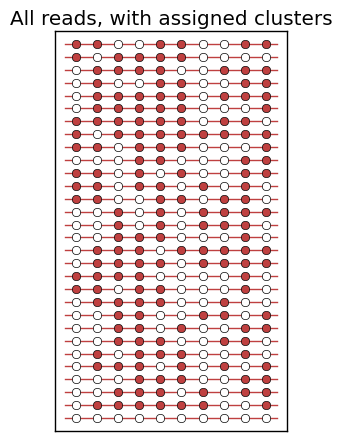

PyObject <matplotlib.text.Text object at 0x7f0e7810f690>

In [6]:
# Plots
figure(figsize=(3,5))
plot_meth(X,ones(N))